In [ ]:
#TODO: improve the sentiment classifier
#TODO: save the sentiment classifier to save time
#TODO: save the ngrams to save time
#TODO: explore the good and bad examples

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/twitter-data/negative-words.txt
/kaggle/input/twitter-data/positive-words.txt
/kaggle/input/twitter-data/twitter_data.txt


In [2]:
df_data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
df_test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
df_sample_submission = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")
print("df_data shape", df_data.shape,"\n", "df_test shape", df_test.shape)

df_data shape (27486, 4) 
 df_test shape (3535, 3)


In [3]:
df_data = df_data[~df_data.text.isnull()]
df_data.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_data["label"] = le.fit_transform(df_data.sentiment)
print(le.classes_)

['negative' 'neutral' 'positive']


In [5]:
df_data.head()

,textID,text,selected_text,sentiment,label
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,2


In [6]:
from sklearn.model_selection import train_test_split

df_train, df_dev = train_test_split(df_data, test_size=0.2, random_state=42)
print(df_data.shape, df_train.shape, df_dev.shape)

(27485, 5) (21988, 5) (5497, 5)


In [7]:
y_train = df_train["label"]
y_dev = df_dev["label"]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(df_train["selected_text"])
X_dev = vectorizer.transform(df_dev["selected_text"])

print(vectorizer.get_feature_names()[:10])
print(X_train.shape, X_dev.shape)
print(y_train.shape, y_dev.shape)

['00', '000', '007', '01', '02', '03', '04', '05', '06', '060']
(21988, 15142) (5497, 15142)
(21988,) (5497,)


In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import regularizers

In [60]:
def baseline_model(n_x=5, n_h=X_train.shape[1], n_o=3):
    # create model
    model = Sequential()
    model.add(Dense(n_x, input_dim=n_h, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(n_x, input_dim=n_x, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(n_o, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
    print(model.summary())
    return model

In [61]:
model = baseline_model()
model.fit(X_train.todense(), y_train, epochs=20, batch_size=32)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 5)                 75715     
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 18        
Total params: 75,763
Trainable params: 75,763
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
21988/21988 [==============================] - 4s 184us/step - loss: 1.0880 - sparse_categorical_accuracy: 0.4489
Epoch 2/20
21988/21988 [==============================] - 3s 139us/step - loss: 0.9748 - sparse_categorical_accuracy: 0.6669
Epoch 3/20
21988/21988 [==============================] - 3s 145us/step - loss: 0.8822 - sparse_categorical_accuracy: 0.7421

In [62]:
score = model.evaluate(X_dev, y_dev, batch_size=32)
print(score)

5497/5497 [==============================] - 0s 73us/step
[0.7501042876890709, 0.7893396615982056]


In [63]:
df_dev.head()

,textID,text,selected_text,sentiment,label,number_of_words_in_text
7534,f07cf90a98,is missing out on the sunshine and trying to s...,is missing out on the sunshine and trying to s...,neutral,1,17
2664,95ce0e14ce,- i sure hope so it was worth it for me too ...,- i sure hope so it was worth it for me too ...,positive,2,13
12943,80775bf0e3,http://twitpic.com/4jccd - and also these hi t...,http://twitpic.com/4jccd - and also these hi t...,neutral,1,11
23884,60ce7c4890,The little weeping nervous girl was put throu...,The little weeping nervous girl was put throug...,neutral,1,24
4104,cc1af9564d,"maybe someday. i lova ya, friends!! my compute...","maybe someday. i lova ya, friends!! my compute...",neutral,1,16


In [64]:
df_dev["number_of_words_in_text"] = df_dev.text.str.split().str.len()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
df_ngrams = pd.DataFrame()
for i in range(df_dev["text"].shape[0]):
    if i%1000==0:
        print(i)
    try:
        vectorizer_tmp = TfidfVectorizer(ngram_range=(1,df_dev.iloc[i]["number_of_words_in_text"]),token_pattern=r'\S+')
        ngrams = vectorizer_tmp.fit([df_dev.iloc[i]["text"]]).get_feature_names()
        df_tmp = pd.DataFrame({
            "textID":df_dev.iloc[i]["textID"],
            "selected_text":df_dev.iloc[i]["selected_text"],
            "selected_text_predict":ngrams,
            "label":df_dev.iloc[i]["label"]
        })
        df_ngrams = pd.concat([df_ngrams,df_tmp])
    except Exception as e:
        print("problem with ", i)
        pass
#           print(e)
# dev_vect = 
# dev_vect.get_feature_names()

0
1000
2000
3000
4000
5000


In [66]:
df_ngrams.shape

(615874, 4)

In [67]:
X_to_predict = vectorizer.transform(df_ngrams["selected_text_predict"])
y_pred = model.predict(X_to_predict, verbose=1)

615874/615874 [==============================] - 39s 63us/step


In [68]:
df_ngrams["pred1"] = y_pred[:,0]
df_ngrams["pred2"] = y_pred[:,1]
df_ngrams["pred3"] = y_pred[:,2]

In [69]:
df_ngrams.loc[df_ngrams.label==0,"final_pred"] = df_ngrams.loc[df_ngrams.label==0,"pred1"] 
df_ngrams.loc[df_ngrams.label==1,"final_pred"] = df_ngrams.loc[df_ngrams.label==1,"pred2"] 
df_ngrams.loc[df_ngrams.label==2,"final_pred"] = df_ngrams.loc[df_ngrams.label==2,"pred3"] 

In [70]:
df_ngrams.head(10)

,textID,selected_text,selected_text_predict,label,pred1,pred2,pred3,final_pred
0,f07cf90a98,is missing out on the sunshine and trying to s...,2,1,0.360357,0.351486,0.288157,0.351486
1,f07cf90a98,is missing out on the sunshine and trying to s...,2 hours,1,0.144309,0.771533,0.084159,0.771533
2,f07cf90a98,is missing out on the sunshine and trying to s...,2 hours sleep,1,0.206872,0.752939,0.040189,0.752939
3,f07cf90a98,is missing out on the sunshine and trying to s...,after,1,0.360357,0.351486,0.288157,0.351486
4,f07cf90a98,is missing out on the sunshine and trying to s...,after having,1,0.543908,0.375006,0.081086,0.375006
5,f07cf90a98,is missing out on the sunshine and trying to s...,after having just,1,0.324669,0.633158,0.042173,0.633158
6,f07cf90a98,is missing out on the sunshine and trying to s...,after having just 2,1,0.324669,0.633158,0.042173,0.633158
7,f07cf90a98,is missing out on the sunshine and trying to s...,after having just 2 hours,1,0.162610,0.810799,0.026591,0.810799
8,f07cf90a98,is missing out on the sunshine and trying to s...,after having just 2 hours sleep,1,0.190841,0.793212,0.015947,0.793212
9,f07cf90a98,is missing out on the sunshine and trying to s...,and,1,0.360357,0.351486,0.288157,0.351486


In [71]:
df_ngrams["len_selected_text_predict"] = df_ngrams.selected_text_predict.str.len()
df_ngrams.sort_values(by=['len_selected_text_predict'], ascending=False, inplace=True)

In [72]:
idx = df_ngrams.groupby(['textID'])['final_pred'].transform(max) == df_ngrams['final_pred']

In [73]:
df_dev_final = df_ngrams[idx].drop_duplicates(subset='textID', keep="first")

In [74]:
df_dev_enriched = pd.merge(df_dev, df_dev_final[["textID","selected_text_predict"]], on='textID', how='left')

In [75]:
df_dev_enriched.loc[df_dev_enriched.selected_text_predict.isnull(),"selected_text_predict"] = df_dev_enriched.loc[df_dev_enriched.selected_text_predict.isnull(),"text"] 

In [76]:
# 58% is the accuracy when selected text is equal to text!! 

In [77]:
def jaccard(strs): 
    str1=strs['selected_text']
    str2=strs['selected_text_predict']
    
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

Average jaccard index in training data 0.44010662152986213


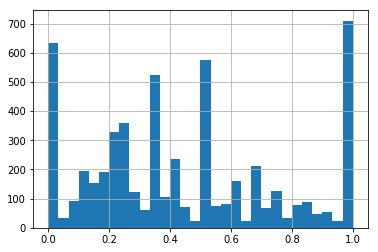

In [78]:
df_dev_enriched['jaccard']=df_dev_enriched[['selected_text','selected_text_predict']].apply(lambda x: jaccard(x),axis=1)

print(f"Average jaccard index in training data {df_dev_enriched['jaccard'].mean()}")
df_dev_enriched['jaccard'].hist(bins=30)

Average jaccard index in training data 0.5878679493589238


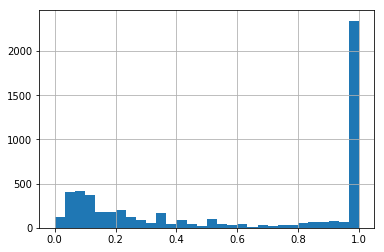

In [80]:
df_dev_enriched_baseline = df_dev_enriched.copy()
df_dev_enriched_baseline["selected_text_predict"]= df_dev_enriched_baseline["text"]
df_dev_enriched_baseline['jaccard']=df_dev_enriched_baseline[['selected_text','selected_text_predict']].apply(lambda x: jaccard(x),axis=1)
print(f"Average jaccard index in training data {df_dev_enriched_baseline['jaccard'].mean()}")
df_dev_enriched_baseline['jaccard'].hist(bins=30)

In [93]:
# Good predictions
print("Good Predictions\n__________")
df_sample = df_dev_enriched[df_dev_enriched.jaccard > .9]
for i in range(10):
    print("textID:    ", df_sample.iloc[i]["textID"])
    print("sentiment: ", df_sample.iloc[i]["sentiment"])
    print("original:  ", df_sample.iloc[i]["text"])
    print("target:    " , df_sample.iloc[i]["selected_text"])
    print("prediction:", df_sample.iloc[i]["selected_text_predict"])    
    print("--")
    
# Bad predictions
print("Bad Predictions\n__________")
df_sample = df_dev_enriched[df_dev_enriched.jaccard < .1]
for i in range(10):
    print("textID:    ", df_sample.iloc[i]["textID"])
    print("sentiment: ", df_sample.iloc[i]["sentiment"])
    print("original:  ", df_sample.iloc[i]["text"])
    print("target:    " , df_sample.iloc[i]["selected_text"])
    print("prediction:", df_sample.iloc[i]["selected_text_predict"])    
    print("--")

Good Predictions
__________
textID:     80775bf0e3
sentiment:  neutral
original:   http://twitpic.com/4jccd - and also these hi top Reeboks.  cause i can
target:     http://twitpic.com/4jccd - and also these hi top Reeboks.  cause i can
prediction: http://twitpic.com/4jccd - and also these hi top reeboks. cause i can
--
textID:     c92b5a0bf7
sentiment:  neutral
original:    ahh seen a few of those drop, but I just tossed them thinking it was a once only turn in
target:     ahh seen a few of those drop, but I just tossed them thinking it was a once only turn in
prediction: seen a few of those drop, but i just tossed them thinking it was a once only turn in
--
textID:     d7dff2ead4
sentiment:  neutral
original:   Jennnnnn richhhh wast to the ed
target:     Jennnnnn richhhh wast to the ed
prediction: jennnnnn richhhh wast to the ed
--
textID:     e5d6992ece
sentiment:  negative
original:   My arms hurt
target:     hurt
prediction: hurt
--
textID:     b9f42cee04
sentiment:  positive
orig

In [ ]:
df_ngrams[df_ngrams.textID == "3e9e3f0d69"]

In [94]:
df_dev_enriched[df_dev_enriched.textID == "3e9e3f0d69"]

,textID,text,selected_text,sentiment,label,number_of_words_in_text,selected_text_predict,jaccard
65,3e9e3f0d69,"nah, you're just altered forever Enjoy.",you're just altered forever Enjoy,positive,2,6,enjoy.,0.0
